In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import random
import time

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
pretrained = "twitter.27B.50d"

In [6]:
name = ".".join(pretrained.split('.')[:2])
dim = int(pretrained.split('.')[-1].replace('d',''))

In [7]:
sys.path.append('..')
from datasets import imdb as dataset
import TextCNN.models.textcnn as textcnn

In [8]:
from vae import *

In [9]:
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
#Options
params = {'text.usetex' : False,
          'font.size' : 21,
         }
plt.rcParams.update(params)

In [10]:
dataset_name = 'rt'

In [11]:
if dataset_name == 'imdb':
    dataset_root = '/ksozykinraid/data/nlp/IMDB/'
    dataset.split_train_valid(path_data='{}/imdb.csv'.format(dataset_root))
    pth = torch.load('{}/imdb_text_cnn_best_twitter27b50d.pth'.format(dataset_root),map_location='cpu')
elif dataset_name == 'rt':
    dataset_root = './'
    dataset.split_train_valid(path_data='{}/rt-polarity.csv'.format(dataset_root))
    pth = torch.load('{}/rt-polarity_twitter.27B.50d_text_cnn_best.pth'.format(dataset_root),map_location='cpu')

Spliting original file to train/valid set...


In [12]:
fix_length=32
batch_size = 64

In [13]:
dataset = dataset.IMDB_Dataset(pretrained=pretrained,fix_length=fix_length,mbsize=batch_size)

Preprocessing the text...


.vector_cache/glove.twitter.27B.zip: 1.52GB [13:26, 1.89MB/s]                               
100%|█████████▉| 1191667/1193514 [00:52<00:00, 22455.74it/s]The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [14]:
V = dataset.TEXT.vocab

In [15]:
target = textcnn.textCNN(V, 100, [3,4,5], 0.5 , 2)
target.load_state_dict(pth['state_dict'])
target.embed = feedEmbed(target.embed )
device='cuda'
target = target.to(device)

In [16]:
device='cuda'
disc = textcnn.textCNN(V, 100, [3,4,5], 0.5 , 2)
disc.embed = target.embed 
disc = disc.to(device)

In [17]:
disable_all_grads(target)

In [18]:
if not os.path.exists('pth/'):
    os.makedirs('pth/')
if not os.path.exists('pth_re_train/'):
    os.makedirs('pth_re_train/')


In [19]:
itos = dataset.LABEL.vocab.itos

In [20]:
h_dim = 32
lr_decay_every = 1000

In [21]:
dataset.n_train_batch

133

In [22]:
model = RNN_VAE(
    dataset.n_vocab, h_dim,h_dim,2, p_word_dropout=0.3,
    pretrained_embeddings=dataset.get_vocab_vectors(), freeze_embeddings=False,max_sent_len=fix_length,
    gpu=True
)

In [23]:
def batch_itos(x):
    return [" ".join([V.itos[e] for e in s]) for s in x]

In [24]:
def perplexity(p):
    # [seq_len,probs]
    # per 1 elem in batch
    # as in paper
    with torch.no_grad():
        #ppl = -torch.log(F.softmax(p,-1)).sum(1).sum(0)/len(V)
        ppl = -F.log_softmax(p,-1).sum(1).sum(0)/len(V)
        return ppl.cpu().numpy()

In [25]:
def save_model(re_train,model,disc,phi):
    pth = {}
    pth['state_dict'] = model.state_dict()
    pth['disc_state_dict'] = disc.state_dict()
    root = './pth' if not re_train else './pth_re_train'
    torch.save(pth, '{}/vae_phi{}.pth'.format(root,phi))

In [26]:
def test_attack_rate(N):
    j = 0
    rate = []
    perp = []
    for _ in range(N):
        z = model.sample_z_prior(1)
        c = model.sample_c_prior(1)
        z=torch.cat([z,model.C[torch.argmax(c)].unsqueeze(0)],-1)


        sample_idxs,sample_logits = model.sample_sentence(z, c,temp=0.8)
        sample_sent = dataset.idxs2sentence(sample_idxs)
        ppl = perplexity(sample_logits)
        sample_logits = sample_logits.unsqueeze(0)


        if sample_logits.shape[1] < 5:
            continue
        j += 1
        if j >= N:
            break
        c_idx = torch.argmax(c,-1).cpu().numpy()[0]
        pred_label_idx =  torch.argmax(target(sample_logits),-1)[0].cpu().numpy()
        rate.append(c_idx !=  pred_label_idx)
        perp.append(ppl)
    perp = np.mean(ppl)
    attack_rate=np.mean(rate)
    return attack_rate,perp

In [27]:
with_disriminator = True
from_scratch = False # do we used checkpoints or not
from_scratch_re_train = False
generate_and_save = False # used for re-training on adversarial data
tune_on_z  = False # used for re-training on adversarial data

In [28]:
beta1 = 0.9

In [29]:

def train(phi = 0,
          num_epochs=5,
          log_interval = 10,
          re_train=False,
          lr = 1e-2,
          gen_batch_size=8):
    vanila = (phi == 0)
    print("phi={}".format(phi))
    n_iter = num_epochs*dataset.n_train_batch
    # Annealing for KL term
    kld_start_inc = 1000
    kld_weight = 0.0
    kld_max = 1
    if not vanila:
        kld_weight =  kld_max
    kld_inc = (kld_max - kld_weight) / (n_iter - kld_start_inc)
    it = 0
    loss_data = []
    recon_loss_data = []
    kl_loss_data = []
    opt = optim.Adam(model.vae_params + list(target.parameters()), lr=lr,betas=(beta1, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=lr,betas=(beta1, 0.999))
    for epoch in range(num_epochs):
      #print("epoch",epoch)
      for idx,batch in enumerate(dataset.train_iter):
            x, labels = batch.text, batch.label
            c  = torch.eye(2)[labels]
            x, labels = x.to(device), labels.to(device)
            c = c.to(device)

            recon_loss, kl_loss, x_hat = model.forward(x,c)
            loss = recon_loss + kld_weight * kl_loss


            #Anneal kl_weight
            if it > kld_start_inc and kld_weight < kld_max:
                kld_weight += kld_inc

            loss = loss.reshape(1)
            attack_rate = 0

            if not vanila:
                x_adv, labels_adv = model.generate_sentences(gen_batch_size)
                pred_adv = target(x_adv)
                Ladv = F.cross_entropy(pred_adv,torch.argmax(labels_adv.long(),-1))

                labels_adv_idx =  torch.argmax(labels_adv.long(),-1).cpu().numpy()
                pred_label_idx =  torch.argmax(pred_adv,-1).cpu().numpy()

                attack_rate=np.mean((labels_adv_idx !=  pred_label_idx))
                
                loss -= phi*Ladv
                
                if with_disriminator:
                    x_real = torch.eye(len(V))[x].to(device)
                    x_real = torch.transpose(x_real,0, 1)
                    pred_real = disc(x_real)
                    Ldisc_real = F.cross_entropy(pred_real,labels)
                    Ldisc_real.backward()
                    #https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
                    pred_fake = disc(x_adv.detach())
                    Ldisc_fake = F.cross_entropy(pred_fake,torch.argmax(labels_adv.long(),-1))
                    Ldisc_fake.backward()

                    Ldisc = Ldisc_real + Ldisc_fake
                    grad_norm = torch.nn.utils.clip_grad_norm(disc.parameters(), 1)
                    opt_disc.step()
                    opt_disc.zero_grad()
                    loss += loss + Ldisc.detach()

                
                #print('loss',loss.data)

            loss.backward()
            #grad_norm = torch.nn.utils.clip_grad_norm(model.vae_params, 1)
            opt.step()
            opt.zero_grad()

            loss_data.append(loss.data)
            recon_loss_data.append(recon_loss.reshape(1).data)
            kl_loss_data.append(kl_loss.reshape(1).data)


            if it % log_interval == 0:

                save_model(re_train,model,disc,phi)
                x_text = batch_itos(x)
                x_text_hat = batch_itos(torch.argmax(x_hat,-1))

                z = model.sample_z_prior(1)
                c = model.sample_c_prior(1)
                z=torch.cat([z,model.C[torch.argmax(c)].unsqueeze(0)],-1)

                sample_idxs,sample_logits = model.sample_sentence(z, c)
                sample_sent = dataset.idxs2sentence(sample_idxs)

                sample_logits = sample_logits.unsqueeze(0)

                if sample_logits.shape[1] < 5:
                    continue

                pred_label_idx =  torch.argmax(target(sample_logits),-1)[0]

                c_idx = torch.argmax(c)
                print('epoch-%d Iter-%d; Loss: %9.4f; Recon: %9.4f; KL: %9.4f;'%(epoch,it, loss.data, 
                                                                                 recon_loss.data, kl_loss.data))
                print(sample_sent)
                print('sampled',itos[c_idx],'predicted',itos[pred_label_idx])
                print('attack_rate per batch',attack_rate)
                print('perplexity per sampled sentance',perplexity(sample_logits[0]))
                print()
            # Anneal learning rate
            #new_lr = lr * (0.5 ** (it // lr_decay_every))
            #for param_group in opt.param_groups:
            #    param_group['lr'] = new_lr
            it += 1
    
    return loss_data,recon_loss_data, kl_loss_data 

In [30]:
log_interval =  1000

In [31]:
if from_scratch:
    loss_data0,recon_loss_data0, kl_loss_data0 = train(phi=0,num_epochs=50,log_interval = log_interval)
    a,ppl = test_attack_rate(500)
    print(a)


In [32]:
if from_scratch:
    LD = []
    RLD = []
    KLD = []
    for i in range(0, len(loss_data0)):
        LD.append(loss_data0[i].data.cpu().numpy()[0])
        RLD.append(recon_loss_data0[i].data.cpu().numpy()[0])
        KLD.append(kl_loss_data0[i].data.cpu().numpy()[0])


    plt.figure(facecolor='white')
    plt.plot(LD[::10], marker='o',label='LD')
    plt.plot(RLD[::10], marker='o',label='RLD')
    plt.plot(KLD[::10], marker='o',label='KLD')
    plt.grid()
    plt.legend()

In [33]:
phis=[0,1,3,6,9]

In [34]:
if from_scratch:
    
    for phi in phis[1:]:
        vae_phi0_pth = torch.load('./pth/vae_phi0.pth',map_location='cpu')
        try:
            model.load_state_dict(vae_phi0_pth['state_dict'])
            
            disc = textcnn.textCNN(V, 100, [3,4,5], 0.5 , 2)
            disc.embed = target.embed 
            disc = disc.to(device)
            model.eval()

            disable_all_grads_enoder(model)
        except:
            pass
        log_interval = 100
        num_epochs = 3
        loss_data,recon_loss_data, kl_loss_data = train(phi=phi,num_epochs=num_epochs,lr = 1e-2,
                                                        log_interval = log_interval)
        a,ppl = test_attack_rate(500)
        print('test attack rate',a)
        print('test ppl',ppl)
        #attack_rates_test.append(a)

In [35]:
def get_metrics(root='./pth',phis=[0,1,3,6,9],verbose=False,n_samples=500):
    at = []
    perp = []
    for phi in phis:
        if verbose:
            print(phi)
        vae_phi0_pth = torch.load('{}/vae_phi{}.pth'.format(root,phi),map_location='cpu')
        try:
            model.load_state_dict(vae_phi0_pth['state_dict'])
            model.eval()
        except:
            pass
        a,ppl = test_attack_rate(n_samples)
        if verbose:
            print('test attack rate',a)
            print('test ppl',ppl)
        perp.append(ppl)
        at.append(a)
    model.train()
    return phis,at,perp

In [36]:
N_trials = 4

In [37]:
phis0,at0,perp0 = [],[],[]

In [38]:
for i in tqdm(range(N_trials)):
    phis_,at_,perp_ = get_metrics(phis=phis)
    phis0.append(phis_)
    at0.append(at_)
    perp0.append(perp_)
phis0 = np.array(phis0).mean(0)
at0 = np.array(at0).mean(0)
perp0 = np.array(perp0).mean(0)



100%|██████████| 4/4 [04:41<00:00, 70.34s/it]


In [39]:
def plot_plots(phis_,at_,perp_):
    print('phis:',phis_)
    print('attack_rates:',at_)
    print('ppl:',perp_)
    plt.figure(facecolor='white',figsize=(20,20))
    plt.subplot(2,1,1)
    plt.plot(phis_,at_,marker='o',color='red',lw=4,markersize=12)
    plt.grid()
    plt.xlabel("phi")
    plt.ylabel("attack rate")
    plt.ylim(0)
    plt.subplot(2,1,2)
    plt.plot(phis_,perp_,marker='o',color='g',lw=4,markersize=12)
    plt.grid()
    plt.xlabel("phi")
    plt.ylabel("perplexity")
    plt.ylim(0)

phis: [0. 1. 3. 6. 9.]
attack_rates: [0.1840687  0.79208417 0.72745491 0.69288577 0.98697395]
ppl: [ 359.08627 1274.021   1184.9601  1676.6401  1785.2588 ]


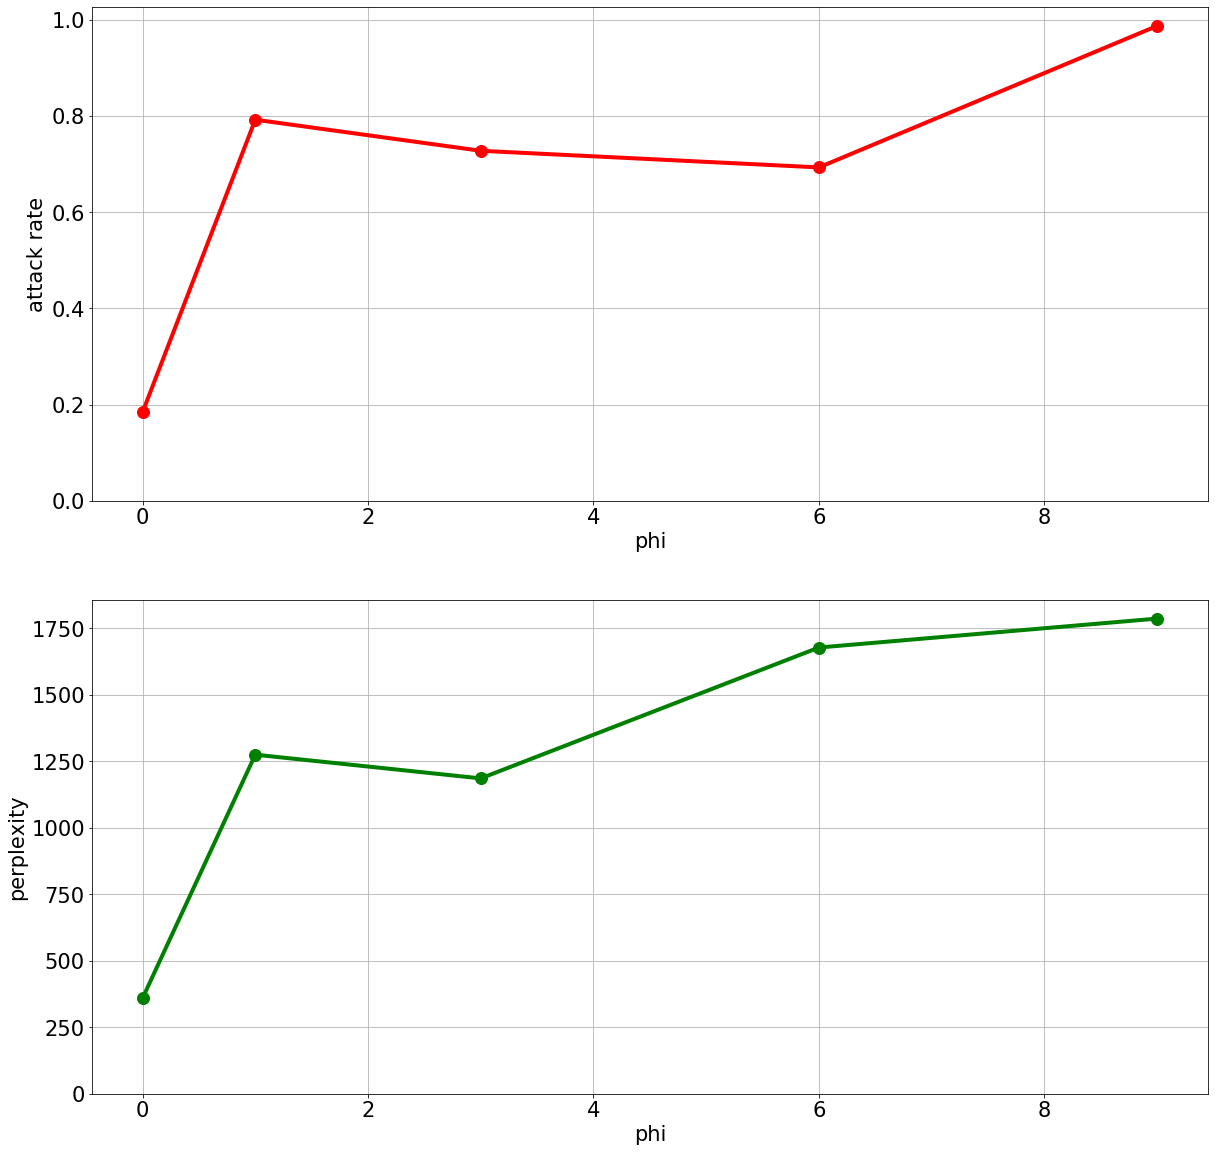

In [40]:
plot_plots(phis0,at0,perp0)

## Samples for validity rate

In [41]:
samples = []

In [42]:

for phi in phis:
    vae_phi_pth = torch.load('./pth/vae_phi{}.pth'.format(phi),map_location='cpu')
    try:
        model.load_state_dict(vae_phi_pth['state_dict'])
        disable_all_grads_enoder(model)
    except:
        pass
    for i in range(batch_size):
        z = model.sample_z_prior(1)
        c = model.sample_c_prior(1)
        z=torch.cat([z,model.C[torch.argmax(c)].unsqueeze(0)],-1)

        sample_idxs,sample_logits = model.sample_sentence(z, c,temp=0.8)
        sample_sent = dataset.idxs2sentence(sample_idxs)
        lb = torch.argmax(c)
        sample_label = itos[lb]
        samples.append([phi,sample_sent,sample_label])

In [43]:
samples = pd.DataFrame(samples)
samples.columns = ['phi','sample_sent','sample_label',]

In [44]:
samples.to_csv('validity_rate_sample.csv',index=None)

In [45]:
samples.head()

,phi,sample_sent,sample_label
0,0,a moving and weighty depiction of the mysterie...,positive
1,0,a moving and weighty depiction of the mysterie...,positive
2,0,"a movie that 's a nice twists , and a host of ...",positive
3,0,the film 's a toy chest contents off,negative
4,0,a movie that 's a nice charmer,positive


## Re-training

In [46]:

N_adv = 6000//batch_size
if generate_and_save:
    vae_phi9_pth = torch.load('./pth/vae_phi{}.pth'.format(phis[-1]),map_location='cpu')
    try:
        model.load_state_dict(vae_phi0_pth['state_dict'])
            
        disc = textcnn.textCNN(V, 100, [3,4,5], 0.5 , 2)
        disc.embed = target.embed 
        disc = disc.to(device)
        model.eval()

        disable_all_grads_enoder(model)
    except:
        pass
    X_adv = []
    L_adv = []
    for i in tqdm(range(N_adv)):
        with torch.no_grad():
            x_adv, labels_adv = model.generate_sentences(batch_size)
            x_adv, labels_adv = x_adv.cpu(), labels_adv.cpu()
            X_adv.append(x_adv)
            L_adv.append(labels_adv)
    adv_data = {}
    adv_data['x'] = X_adv
    adv_data['l'] = L_adv 
    torch.save(adv_data, './adv_data.pth')


In [47]:

if tune_on_z:
    print('re-training')
    target = textcnn.textCNN(V, 100, [3,4,5], 0.5 , 2)
    target.load_state_dict(pth['state_dict'])
    target.embed = feedEmbed(target.embed )
    target = target.to(device)
    enable_all_grads(target)
    optimizer = optim.Adam(target.parameters(), lr=1e-3)
    total_loss = []
    total_attack = []
    it = 0
    for epoch in range(9):
        num_uncorrect = 0
        num_samples = 0
        for x_adv,l_adv in zip(adv_data['x'],adv_data['l']):
            x_adv,l_adv = x_adv.cuda(),l_adv.cuda()
            optimizer.zero_grad()
            pred_adv = target(x_adv)

            Ladv = F.cross_entropy(pred_adv,torch.argmax(l_adv.long(),-1))
            Ladv.backward()
            total_loss.append(Ladv.data.cpu().numpy())
            if it % 100 == 0:
                print(total_loss[-1])
            optimizer.step()
            it += 1
            c_idx = torch.argmax(l_adv,-1).cpu().numpy()
            pred =  torch.argmax(pred_adv,-1).cpu().numpy()
            num_uncorrect += (pred != c_idx).sum()
            num_samples += len(c_idx) 
        a = num_uncorrect/num_samples
        total_attack.append(a)
        print('epoch',epoch,a)
    disable_all_grads(target)

In [48]:
if from_scratch_re_train:
    for phi in phis[1:]:
        vae_phi0_pth = torch.load('./pth/vae_phi{}.pth'.format(phi),map_location='cpu')
        try:
            model.load_state_dict(vae_phi0_pth['state_dict'])
            disc = textcnn.textCNN(V, 100, [3,4,5], 0.5 , 2)
            disc.embed = target.embed 
            disc = disc.to(device)
            model.eval()

            disable_all_grads_enoder(model)
        except:
            pass
        log_interval = 100
        num_epochs = 2
        loss_data,recon_loss_data, kl_loss_data = train(phi=phi,num_epochs=num_epochs,lr = 1e-2,
                                                        log_interval = log_interval,re_train=True)
        a,ppl = test_attack_rate(100)
        print('test attack rate',a)
        print('test ppl',ppl)
        #attack_rates_test.append(a)

In [49]:
!cp ./pth/vae_phi0.pth ./pth_re_train/

In [50]:
phis1,at1,perp1 = [],[],[]

In [51]:
for i in tqdm(range(N_trials)):
    phis_,at_,perp_ = get_metrics(root='./pth_re_train',phis=phis)
    phis1.append(phis_)
    at1.append(at_)
    perp1.append(perp_)
phis1 = np.array(phis1).mean(0)
at1 = np.array(at1).mean(0)
perp1 = np.array(perp1).mean(0)


100%|██████████| 4/4 [04:22<00:00, 65.57s/it]


phis: [0. 1. 3. 6. 9.]
attack_rates: [0.1642378  0.35135894 0.56212425 0.4509018  0.499499  ]
ppl: [ 608.12933  778.8926  1076.3414  1013.19214 1111.9287 ]


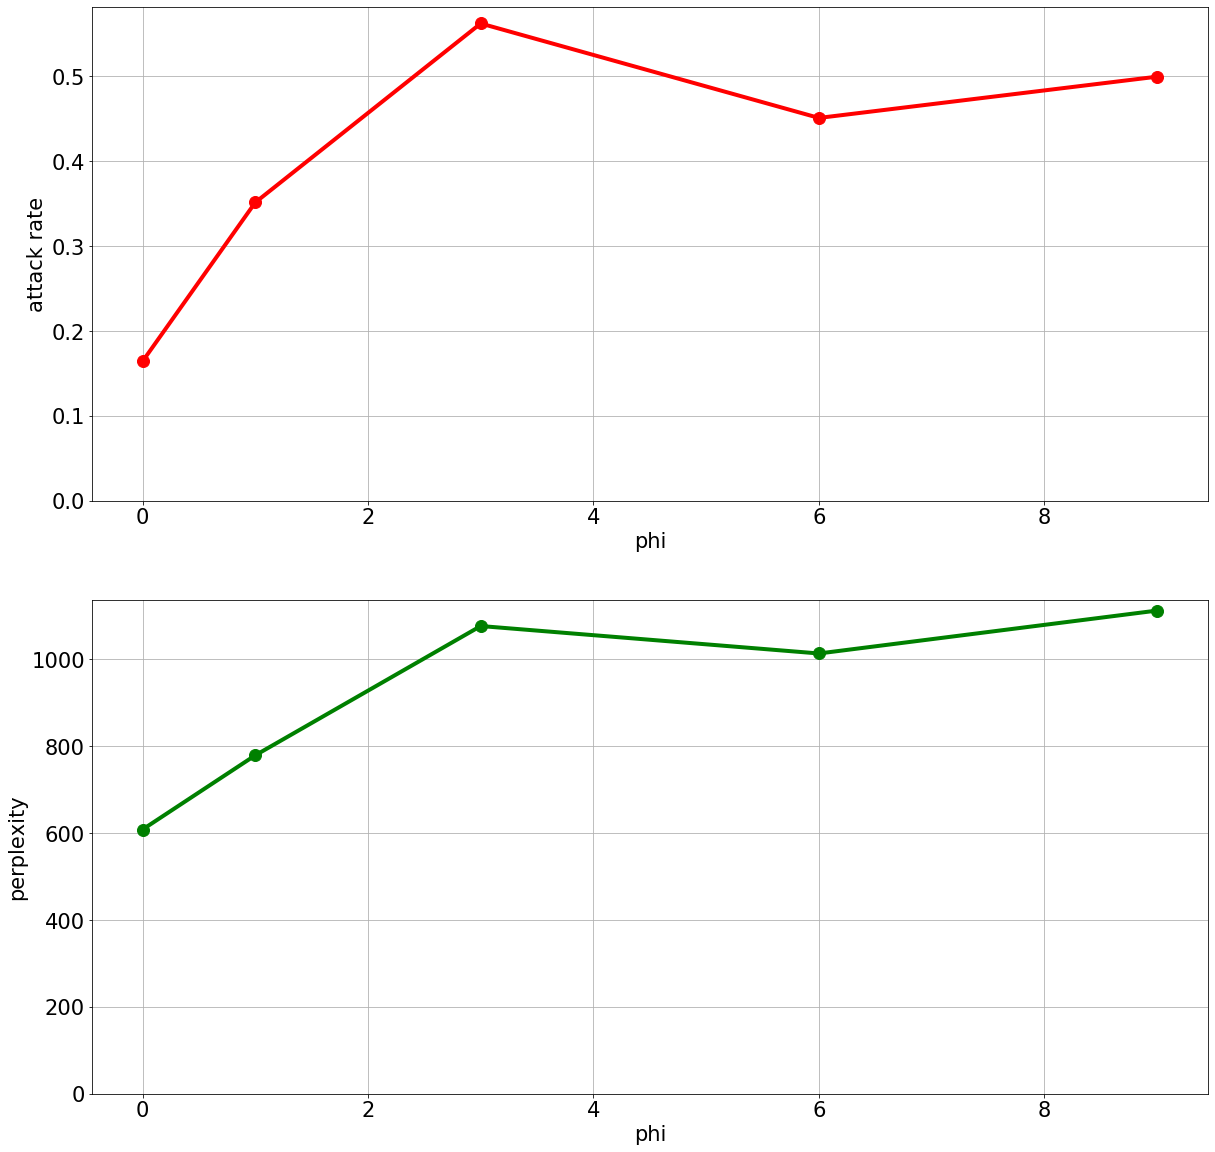

In [52]:
plot_plots(phis1,at1,perp1)

In [53]:
def plot_comp_plots(phis0,at0,perp0,phis1,at1,perp1):
    print('phis:',phis0)
    print('attack_rates:',at0)
    print('ppl:',perp0)
    print('phis:',phis1)
    print('attack_rates:',at1)
    print('ppl:',perp1)
    plt.figure(facecolor='white',figsize=(20,20))
    plt.subplot(2,1,1)
    plt.plot(phis0,at0,marker='o',color='red',label='before re-training',lw=4,markersize=12)
    plt.plot(phis1,at1,marker='o',color='blue',label='after re-training',lw=4,markersize=12)
    plt.grid()
    plt.legend(loc='best',fancybox=True,shadow=True,framealpha=0.99)
    plt.xlabel("phi")
    plt.ylabel("attack rate")
    plt.ylim(0)
    plt.subplot(2,1,2)
    plt.plot(phis0,perp0,marker='o',color='green',label='before re-training',lw=4,markersize=12)
    plt.plot(phis1,perp1,marker='o',color='magenta',label='after re-training',lw=4,markersize=12)
    plt.grid()
    plt.legend(loc='best',fancybox=True,shadow=True,framealpha=0.99)
    plt.xlabel("phi")
    plt.ylabel("perplexity")
    plt.ylim(0)

phis: [0. 1. 3. 6. 9.]
attack_rates: [0.1840687  0.79208417 0.72745491 0.69288577 0.98697395]
ppl: [ 359.08627 1274.021   1184.9601  1676.6401  1785.2588 ]
phis: [0. 1. 3. 6. 9.]
attack_rates: [0.1642378  0.35135894 0.56212425 0.4509018  0.499499  ]
ppl: [ 608.12933  778.8926  1076.3414  1013.19214 1111.9287 ]


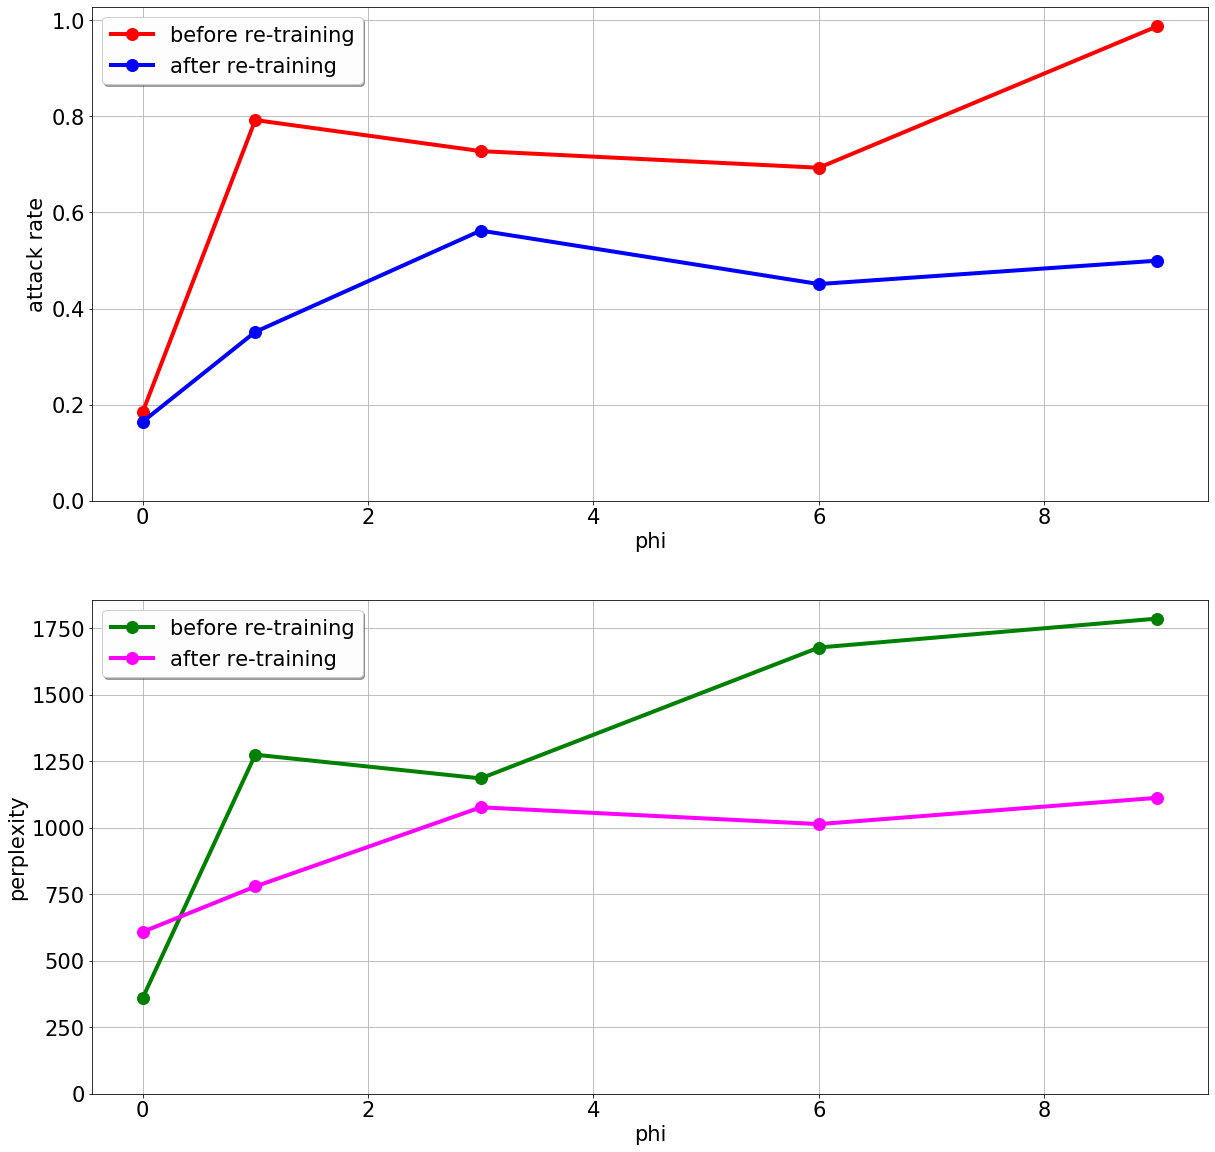

In [54]:
plot_comp_plots(phis0,at0,perp0,phis1,at1,perp1)

In [55]:
print('phis:',phis0)
print('attack_rates:',at0)
print('ppl:',perp0)
print('phis:',phis1)
print('attack_rates:',at1)
print('ppl:',perp1)

phis: [0. 1. 3. 6. 9.]
attack_rates: [0.1840687  0.79208417 0.72745491 0.69288577 0.98697395]
ppl: [ 359.08627 1274.021   1184.9601  1676.6401  1785.2588 ]
phis: [0. 1. 3. 6. 9.]
attack_rates: [0.1642378  0.35135894 0.56212425 0.4509018  0.499499  ]
ppl: [ 608.12933  778.8926  1076.3414  1013.19214 1111.9287 ]


In [56]:
plots_data = {
    
    "phis": phis,
    "attack_rates0": at0,
    "ppl0": perp0,
    "attack_rates1": at1,
    "ppl1": perp1,
}

In [57]:
plots_data

{'phis': [0, 1, 3, 6, 9],
 'attack_rates0': array([0.1840687 , 0.79208417, 0.72745491, 0.69288577, 0.98697395]),
 'ppl0': array([ 359.08627, 1274.021  , 1184.9601 , 1676.6401 , 1785.2588 ],
       dtype=float32),
 'attack_rates1': array([0.1642378 , 0.35135894, 0.56212425, 0.4509018 , 0.499499  ]),
 'ppl1': array([ 608.12933,  778.8926 , 1076.3414 , 1013.19214, 1111.9287 ],
       dtype=float32)}

In [58]:
torch.save(plots_data,"plots_data.pth")